In [3]:
from collections import defaultdict as ddict
import dill
from glob import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
from pprint import pprint
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
import seaborn as sns
import sys; sys.path.append('../')
from tqdm import tqdm

import torch
from torch_geometric.utils import *


from dataloading_utils import load_dataset, load_deprels
from experiment_configs import model_configurations

In [4]:
experiment_config       = 'dep_residual'
spl_dict                = ddict(lambda: ddict(int))

for dataset in ['mscorpus','japflow','risec']:

    configuration       = model_configurations[experiment_config]

    dataset_loaded      = load_dataset(configuration["base_path"], dataset)

    elem                = dataset_loaded['train']['rels'][0]

    for elem in tqdm(dataset_loaded['train']['rels']):
        depgraph_data    = elem['dep_data']
        n1_mask, n2_mask = depgraph_data.n1_mask, depgraph_data.n2_mask
        
        if n1_mask.sum().item() ==1:
            n1_ids  = [(n1_mask==1).nonzero().item()]
        elif n1_mask.sum().item() > 1:
            n1_ids  = list(np.array((n1_mask==1).nonzero().squeeze()))

        if n2_mask.sum().item() ==1:
            n2_ids  = [(n2_mask==1).nonzero().item()]
        elif n2_mask.sum().item() > 1:
            n2_ids  = list(np.array((n2_mask==1).nonzero().squeeze()))

        # if n1_mask.sum().item() ==0 or n2_mask.sum().item() ==0:
        #     import pdb; pdb.set_trace()

        graph =  to_networkx(depgraph_data)
        assert len(graph.nodes()) == len(graph.edges())+1

        graph = graph.to_undirected()
        
        spls  =  []
        for n1 in n1_ids:
            for n2 in n2_ids:
                try:
                    spl = nx.shortest_path_length(graph, n1, n2)
                    spls.append(spl)
                except Exception as e:
                    continue
                
        if min(spls) ==0:
            print(elem['span_info'])
            print(elem['sent'])
            print()
            
            
        spl_dict[dataset][min(spls)]+=1


  2%|▏         | 248/12330 [00:00<00:23, 517.71it/s]

(71, 76, 'doped', 'Property-Misc', 68, 70, 'Ga', 'Nonrecipe-Material', 'Information_Of')
10.1016/j.matlet.2013.01.055
Synthesis and conductive properties of Ga-doped ZnO nanosheets by the hydrothermal method

All chemicals (analytical grade reagents) were purchased from Tianjin Jiangtian Chemicals Co. Ltd. and were used as received without further purification.



 16%|█▌        | 1917/12330 [00:04<00:29, 353.40it/s]

(416, 418, '85', 'Number', 418, 423, 'deg C', 'Condition-Unit', 'Number_Of')

The preparation of Pt/C(b) was: first a mixture of the required quantity of the carbon support (Vulcan XC-72R activated carbon black) and glycol was agitated ultrasonically and the hexachloroplatinic acid solution was added into the mixture at a temperature of 85deg C then, the formic acid solution was added drop by drop to reduce H2PtCl6 at 85deg C for 1 h. Next, the slurry obtained was filtered and washed with triply distilled water until no Cl- was detected.

(499, 501, '85', 'Number', 501, 506, 'deg C', 'Condition-Unit', 'Number_Of')

The preparation of Pt/C(b) was: first a mixture of the required quantity of the carbon support (Vulcan XC-72R activated carbon black) and glycol was agitated ultrasonically and the hexachloroplatinic acid solution was added into the mixture at a temperature of 85deg C then, the formic acid solution was added drop by drop to reduce H2PtCl6 at 85deg C for 1 h. Next, the slurry

 21%|██        | 2541/12330 [00:05<00:22, 435.93it/s]

(694, 698, '1400', 'Number', 698, 702, 'degC', 'Condition-Unit', 'Number_Of')
These compacts were fired at 1400degC in air for 3 h.





 44%|████▎     | 5379/12330 [00:11<00:12, 559.65it/s]

(1856, 1857, '2', 'Number', 1857, 1867, 'degCmin- 1', 'Condition-Unit', 'Number_Of')
Finally, it was calcined in an air flux by increasing the temperature from room temperature to 540 degC with a heating rate of 2degCmin- 1, and holding for 7 h at 540 degC.
Fe-SiO2 was synthesized by a simple batch equilibrium adsorption method.



 45%|████▍     | 5497/12330 [00:12<00:17, 400.80it/s]

(284, 294, 'containing', 'Material-Descriptor', 281, 283, 'Si', 'Nonrecipe-Material', 'Information_Of')


To prepare the Si-containing liquid precursor, 19 g of polymethylhydrosiloxane (Aldrich) was mixed with 1 g of divinyl polydimethylsiloxane (Aldrich) and 0.25 g of a catalyst solution (1wt.% hydrogen hexachloroplatinate in isopropyl alcohol), and the resulting mixture was heated at 70 degC for 2 h. Graphitic flake (GF; KS6, Timcal) powder, which consisted of flakes having an average particle size of 3 μm (vender's value) and thicknesses ranging from 50 to 100 nm, was added into the liquid precursor and stirred for 1 h. The suspension was then filtered to collect solution-coated GFs.

(451, 452, '1', 'Number', 452, 456, 'wt.%', 'Amount-Unit', 'Number_Of')


To prepare the Si-containing liquid precursor, 19 g of polymethylhydrosiloxane (Aldrich) was mixed with 1 g of divinyl polydimethylsiloxane (Aldrich) and 0.25 g of a catalyst solution (1wt.% hydrogen hexachloroplatinate in isopro

 49%|████▉     | 6056/12330 [00:13<00:12, 497.52it/s]

(390, 395, 'thick', 'Property-Type', 387, 389, 'μm', 'Property-Unit', 'Type_Of')
Then, 1.4 μm-thick (TiVCrZrHf)N coatings were deposited at a plasma power of 350 W and a substrate bias of - 100 V in an Ar + N2 mixed atmosphere under a working pressure of 6.67 x 10- 1 Pa at 450 degC. The flow rates of Ar and N2 were maintained at 100 and 4 sccm, respectively.



 51%|█████     | 6278/12330 [00:13<00:12, 479.53it/s]

(338, 342, '1200', 'Number', 342, 346, 'degC', 'Condition-Unit', 'Number_Of')
Stoichiometric amounts of pre-dried high-purity La2O3, SrCO3 and TiO2 (Aldrich) were mixed and ground and then calcined at 1200degC for 6 h. The resulting powder was subsequently ground, mixed and uniaxially pressed into pellets, which were deposited on alumina crucibles containing sacrificial powder and then they were fired at 1400-1600degC for 3-9 days with intermediate processes of grinding, mixing and "pelletizing".

(545, 554, '1400-1600', 'Number', 554, 558, 'degC', 'Condition-Unit', 'Number_Of')
Stoichiometric amounts of pre-dried high-purity La2O3, SrCO3 and TiO2 (Aldrich) were mixed and ground and then calcined at 1200degC for 6 h. The resulting powder was subsequently ground, mixed and uniaxially pressed into pellets, which were deposited on alumina crucibles containing sacrificial powder and then they were fired at 1400-1600degC for 3-9 days with intermediate processes of grinding, mixing and "pell

 59%|█████▊    | 7223/12330 [00:15<00:08, 604.01it/s]

(223, 224, '1', 'Number', 224, 225, 'M', 'Amount-Unit', 'Number_Of')
In a typical synthesis procedure, 3 ml of 1M NH4F was added to 10 ml of 0.1 M Nd(NO3)3 solution.

(867, 868, '5', 'Number', 868, 875, 'deg/min', 'Apparatus-Unit', 'Number_Of')
Powder X-ray diffraction (XRD) patterns of the samples were recorded by RIGAKU-DMAX2500 X-ray diffractometer with Cu Ka radiation (λ = 0.15406 nm) at a scanning rate of 5deg/min for 2θ ranging from 5deg to 85deg.

(896, 897, '5', 'Number', 897, 900, 'deg', 'Apparatus-Unit', 'Number_Of')
Powder X-ray diffraction (XRD) patterns of the samples were recorded by RIGAKU-DMAX2500 X-ray diffractometer with Cu Ka radiation (λ = 0.15406 nm) at a scanning rate of 5deg/min for 2θ ranging from 5deg to 85deg.

(904, 906, '85', 'Number', 906, 909, 'deg', 'Apparatus-Unit', 'Number_Of')
Powder X-ray diffraction (XRD) patterns of the samples were recorded by RIGAKU-DMAX2500 X-ray diffractometer with Cu Ka radiation (λ = 0.15406 nm) at a scanning rate of 5deg/min 

 62%|██████▏   | 7644/12330 [00:16<00:09, 519.44it/s]

(54, 59, 'doped', 'Property-Misc', 51, 53, 'Fe', 'Nonrecipe-Material', 'Information_Of')
10.1016/j.ssi.2010.05.047
Electrical Properties of Fe-doped Perovskite-like BaNb0.75-xFexNa0.25O3-δ (0.05<x<0.5)

A series of BaNa0.25Nb0.75-xFexO3-δ (BNF) compositions (0.05 < x < 0.5) were prepared by conventional solid state synthesis.



 85%|████████▌ | 10505/12330 [00:22<00:03, 552.28it/s]

(462, 465, '900', 'Number', 465, 469, 'sccm', 'Amount-Unit', 'Number_Of')
First, the Cu foils were annealed in argon at 1035 degC in atmospheric pressure for 10 minutes, then graphene was synthesised at the same temperature at a pressure of 25 mbar using a mixture of 900sccm Ar, 60sccm H2 and 2sccm CH4 for 15 minutes.

(474, 476, '60', 'Number', 476, 480, 'sccm', 'Amount-Unit', 'Number_Of')
First, the Cu foils were annealed in argon at 1035 degC in atmospheric pressure for 10 minutes, then graphene was synthesised at the same temperature at a pressure of 25 mbar using a mixture of 900sccm Ar, 60sccm H2 and 2sccm CH4 for 15 minutes.

(488, 489, '2', 'Number', 489, 493, 'sccm', 'Amount-Unit', 'Number_Of')
First, the Cu foils were annealed in argon at 1035 degC in atmospheric pressure for 10 minutes, then graphene was synthesised at the same temperature at a pressure of 25 mbar using a mixture of 900sccm Ar, 60sccm H2 and 2sccm CH4 for 15 minutes.

(739, 742, '300', 'Number', 742, 746, 's

 95%|█████████▌| 11720/12330 [00:25<00:01, 422.59it/s]

(861, 864, '110', 'Number', 864, 868, 'degC', 'Condition-Unit', 'Number_Of')
Hydrothermal synthesis was carried out in an oven at 110degC for 2 h. The products were collected by filtration, washed with distilled water and ethanol several times, and then dried in an oven at 60degC for 6 h.
Surface modification of β-Fe(O)OH was prepared by the mixture of 10 mL of PDCP with 1 g of β-Fe(O)OH.

(1005, 1007, '60', 'Number', 1007, 1011, 'degC', 'Condition-Unit', 'Number_Of')
Hydrothermal synthesis was carried out in an oven at 110degC for 2 h. The products were collected by filtration, washed with distilled water and ethanol several times, and then dried in an oven at 60degC for 6 h.
Surface modification of β-Fe(O)OH was prepared by the mixture of 10 mL of PDCP with 1 g of β-Fe(O)OH.

(1307, 1309, '10', 'Number', 1309, 1313, 'degC', 'Condition-Unit', 'Number_Of')
Then, water (20 mL) was slowly added in to the three-necked, round-bottom flask at 10degC for 5 h. Thereafter, the product was filt

 99%|█████████▊| 12163/12330 [00:26<00:00, 586.92it/s]

(627, 630, '0.1', 'Number', 630, 631, 'M', 'Amount-Unit', 'Number_Of')
The phosphate buffer solution (PBS, 0.1M) was prepared by 0.1M KH2PO4 and 0.1M K2HPO4, and then adjusted the pH with 0.1M H3PO4 and 0.1M KOH solutions.

(649, 652, '0.1', 'Number', 652, 653, 'M', 'Amount-Unit', 'Number_Of')
The phosphate buffer solution (PBS, 0.1M) was prepared by 0.1M KH2PO4 and 0.1M K2HPO4, and then adjusted the pH with 0.1M H3PO4 and 0.1M KOH solutions.

(665, 668, '0.1', 'Number', 668, 669, 'M', 'Amount-Unit', 'Number_Of')
The phosphate buffer solution (PBS, 0.1M) was prepared by 0.1M KH2PO4 and 0.1M K2HPO4, and then adjusted the pH with 0.1M H3PO4 and 0.1M KOH solutions.

(708, 711, '0.1', 'Number', 711, 712, 'M', 'Amount-Unit', 'Number_Of')
The phosphate buffer solution (PBS, 0.1M) was prepared by 0.1M KH2PO4 and 0.1M K2HPO4, and then adjusted the pH with 0.1M H3PO4 and 0.1M KOH solutions.

(723, 726, '0.1', 'Number', 726, 727, 'M', 'Amount-Unit', 'Number_Of')
The phosphate buffer solution (PB

100%|██████████| 12330/12330 [00:26<00:00, 468.49it/s]


(2585, 2588, '120', 'Number', 2588, 2592, 'degC', 'Condition-Unit', 'Number_Of')
The precipitated silica was initially dried at 120degC for 24 h and then dispersed in the ACM solution.

(3532, 3534, '70', 'Number', 3534, 3538, 'degC', 'Condition-Unit', 'Number_Of')
The films were cast over a plain glass plate as before and kept for controlled solvent evaporation for 24 h. In the next phase, peroxide-containing composite films were kept in the oven at 70degC for 2 h for curing, whereas the samples having mixed crosslinked system were cured at 170degC for 30 min.

(3625, 3628, '170', 'Number', 3628, 3632, 'degC', 'Condition-Unit', 'Number_Of')
The films were cast over a plain glass plate as before and kept for controlled solvent evaporation for 24 h. In the next phase, peroxide-containing composite films were kept in the oven at 70degC for 2 h for curing, whereas the samples having mixed crosslinked system were cured at 170degC for 30 min.



100%|██████████| 3689/3689 [00:04<00:00, 752.56it/s] 


## Distribution of dependency distance between the entities

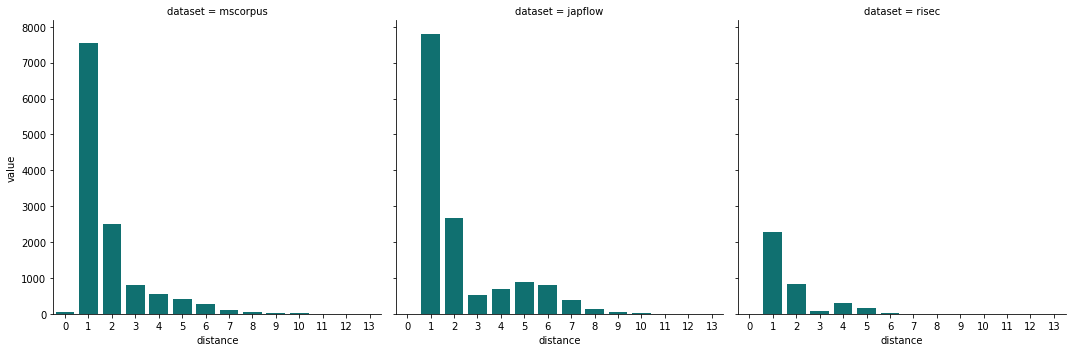

In [5]:
split_dict = ddict(list)

import math

for dataset in spl_dict:
    for dist in spl_dict[dataset]:
        split_dict['dataset'].append(dataset)
        split_dict['distance'].append(dist)
        split_dict['value'].append(spl_dict[dataset][dist])

split_df  = pd.DataFrame(split_dict)

sequential_colors = sns.color_palette("RdPu", 1)

g=sns.catplot(data=split_df, x="distance", y="value", col="dataset",kind="bar", color='teal') 

plt.show()

## How many ent-ent dependency pairs are there for each dataset

In [6]:
experiment_config   = 'dep_residual'
analysis_dict       = ddict(lambda: ddict(list))
configuration       = model_configurations[experiment_config]

deprel_dict         = load_deprels()
id2deprels          = [dep for dep in deprel_dict]

for dataset in ['mscorpus','japflow','risec']:
    dataset_loaded      = load_dataset(configuration["base_path"], dataset)

    for elem in tqdm(dataset_loaded['train']['rels']):
        depgraph_data = elem['dep_data']
        n1_mask, n2_mask = depgraph_data.n1_mask, depgraph_data.n2_mask

        if n1_mask.sum().item() ==1:
            n1_ids  = [(n1_mask==1).nonzero().item()]
        elif n1_mask.sum().item() > 1:
            n1_ids  = list(np.array((n1_mask==1).nonzero().squeeze()))

        if n2_mask.sum().item() ==1:
            n2_ids  = [(n2_mask==1).nonzero().item()]
        elif n2_mask.sum().item() > 1:
            n2_ids = list(np.array((n2_mask==1).nonzero().squeeze()))

        graph =  to_networkx(depgraph_data)
        # print(graph.nodes(), graph.edges())
        assert len(n1_ids) >0 and len(n2_ids) > 0
        assert len(graph.nodes()) == len(graph.edges())+1

        ugraph = graph.to_undirected()
        assert len(ugraph.nodes()) == len(ugraph.edges())+1
        
        
        spls  =  []
        for n1 in n1_ids:
            for n2 in n2_ids:
                spl = nx.shortest_path_length(ugraph, n1, n2)
                spls.append((spl, n1, n2))
            
        spl_val, n1, n2 = min(spls)
        
        if spl_val != 1: continue
        
        n_ids   = list(n1_ids)
        n_ids.extend(n2_ids)
        
        dep = None
        for i in range(0, len(depgraph_data.edge_type)):
            if depgraph_data.edge_index[0][i] in n_ids and depgraph_data.edge_index[1][i] in n_ids :
                dep = id2deprels[depgraph_data.edge_type[i]]
        
        assert dep is not None
        
        
        ent1_type, ent2_type = elem['span_info'][3], elem['span_info'][7]
                
        analysis_dict[dataset][(ent1_type, ent2_type, dep)].append({'span_info': elem['span_info'],\
            'sent': elem['sent'], 'sent_start': elem['sent_start']})
        

100%|██████████| 3689/3689 [00:07<00:00, 461.76it/s]


## Distribution of the dependencies across the different datasets

In [7]:
dep_uni_dict = ddict(lambda: ddict(int))

for dataset in analysis_dict:
    for tup in analysis_dict[dataset]:
        e1, e2, dep = tup
        dep_uni_dict[dataset][dep] +=len(analysis_dict[dataset][tup])


dep_freq_dict = ddict(list)

for dataset in dep_uni_dict:
    for dep in dep_uni_dict[dataset]:
        dep_freq_dict['dataset'].append(dataset)
        dep_freq_dict['dep'].append(dep)
        val = 100*dep_uni_dict[dataset][dep]/sum([dep_uni_dict[dataset][d1] for d1 in dep_uni_dict[dataset]])
        dep_freq_dict['freq'].append(val)

dep_freq_df = pd.DataFrame(dep_freq_dict)

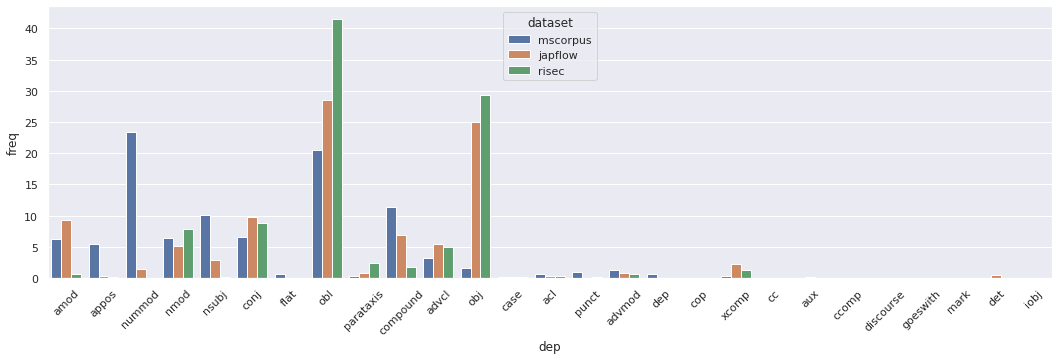

In [8]:
sequential_colors = sns.color_palette("RdPu", 1)

sns.set(rc={'figure.figsize':(18,5)})

g=sns.barplot(data=dep_freq_df, x="dep", y="freq", hue="dataset")

plt.xticks(rotation=45)
plt.show()

## Create the confusion matrices for few-shot training

In [9]:
from collections import defaultdict as ddict
import dill
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
import seaborn as sns


mscorpus_risec_0.01



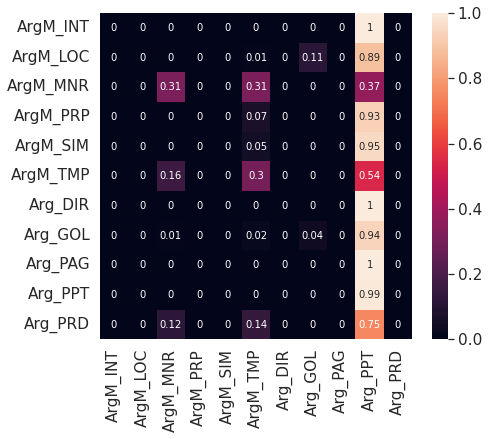

mscorpus_risec_0.05



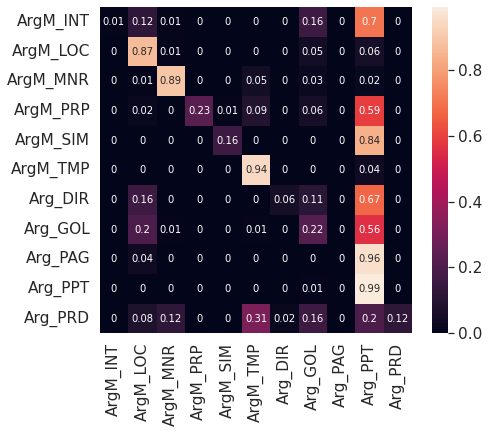

mscorpus_risec_0.1



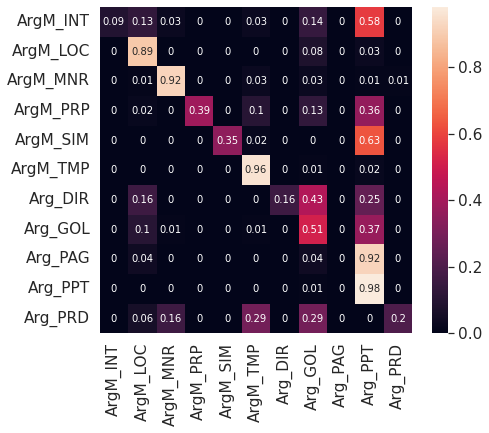

mscorpus_risec_0.2



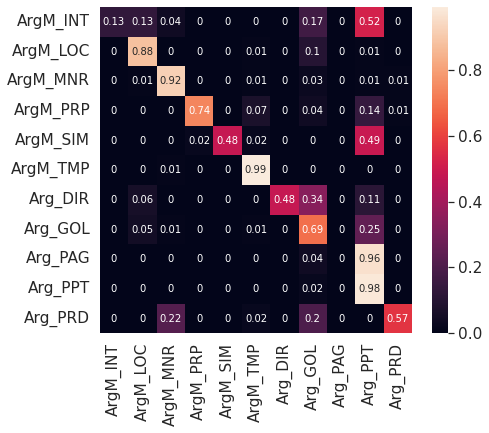

mscorpus_risec_0.5



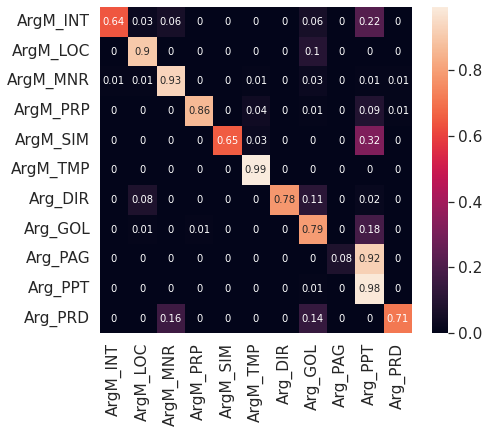

mscorpus_japflow_0.01



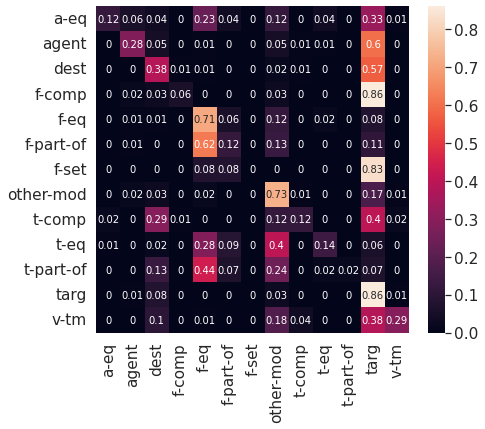

mscorpus_japflow_0.05



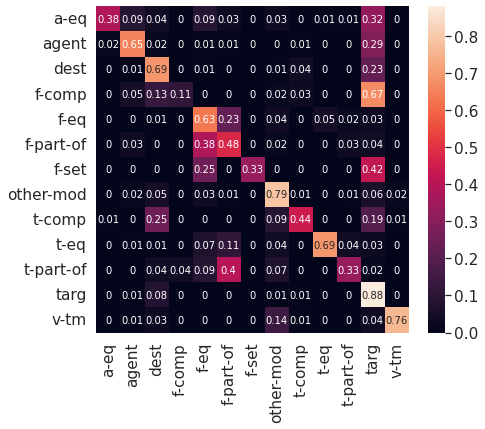

mscorpus_japflow_0.1



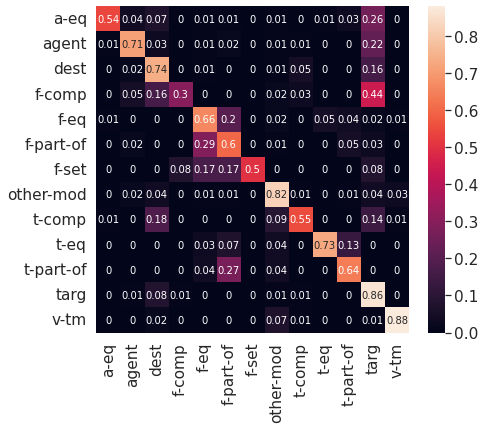

mscorpus_japflow_0.2



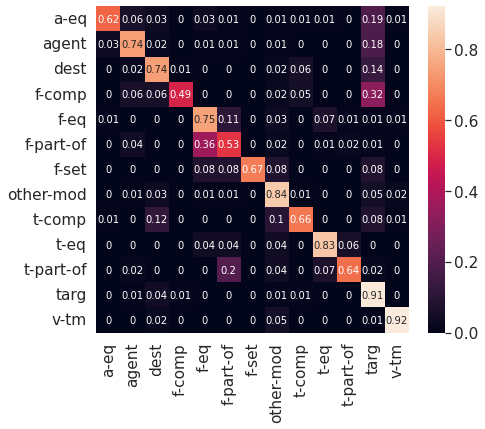

mscorpus_japflow_0.5



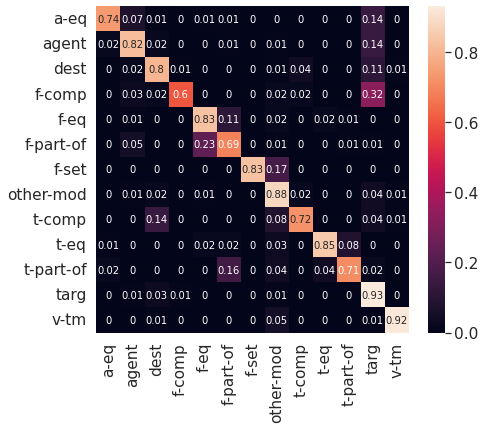

risec_mscorpus_0.01



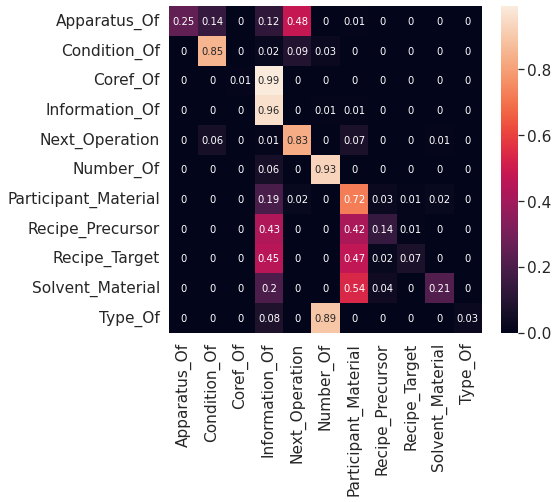

risec_mscorpus_0.05



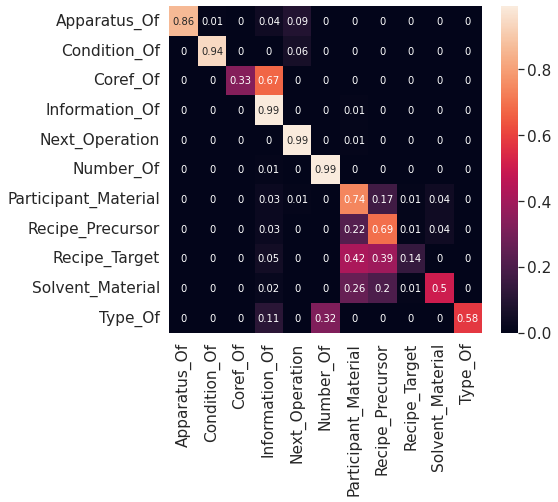

risec_mscorpus_0.1



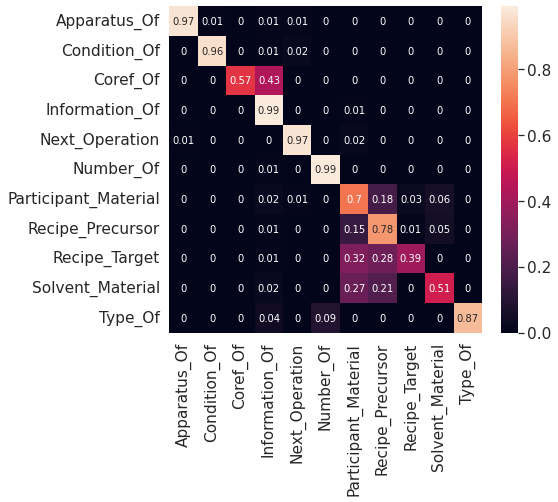

risec_mscorpus_0.2



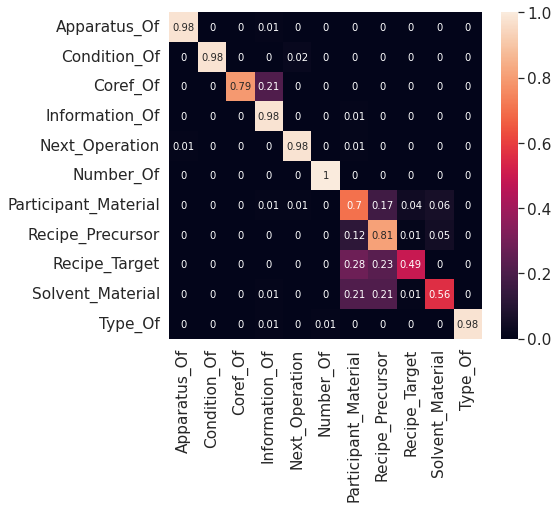

risec_mscorpus_0.5



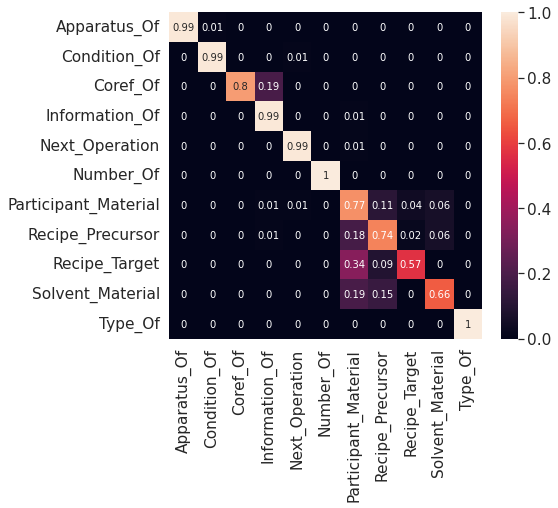

risec_japflow_0.01



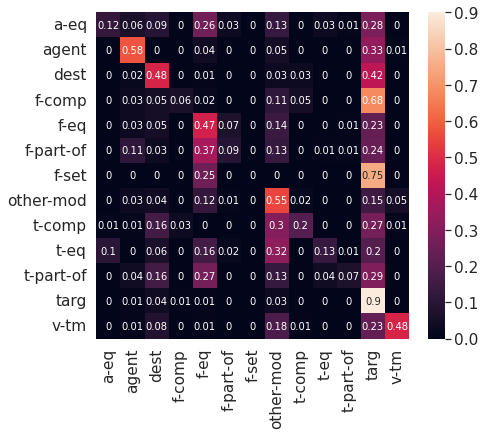

risec_japflow_0.05



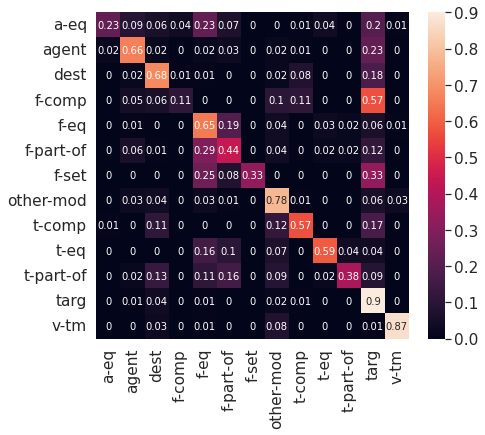

risec_japflow_0.1



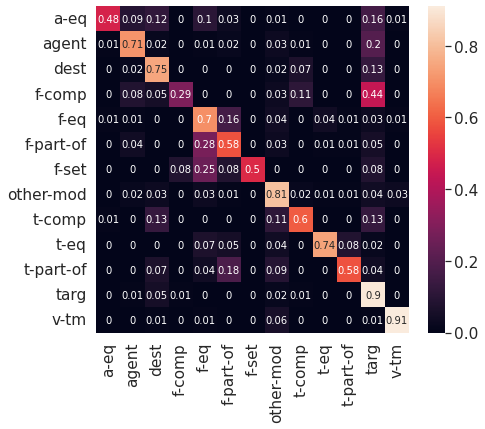

risec_japflow_0.2



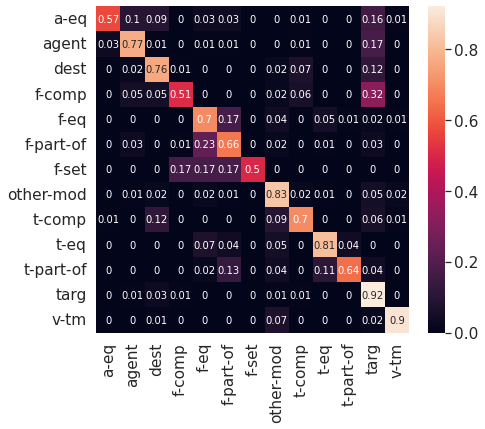

risec_japflow_0.5



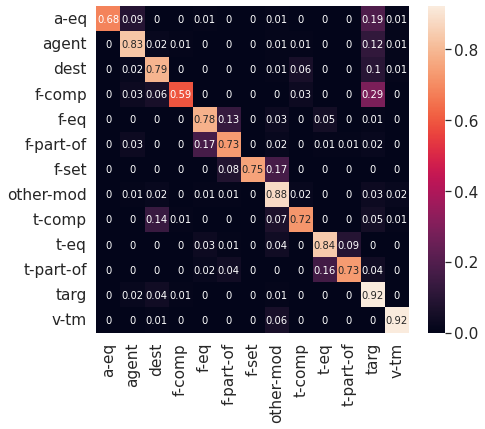

japflow_mscorpus_0.01



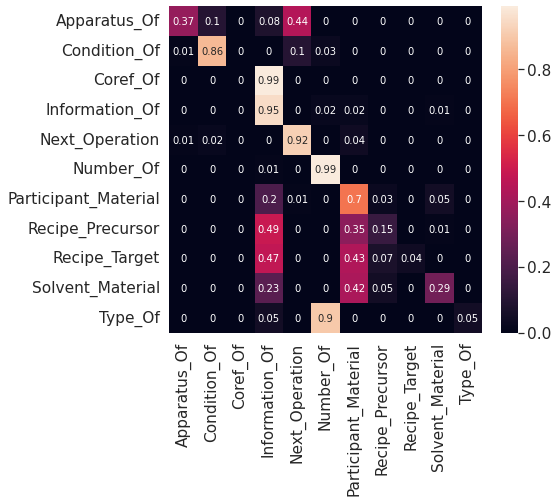

japflow_mscorpus_0.05



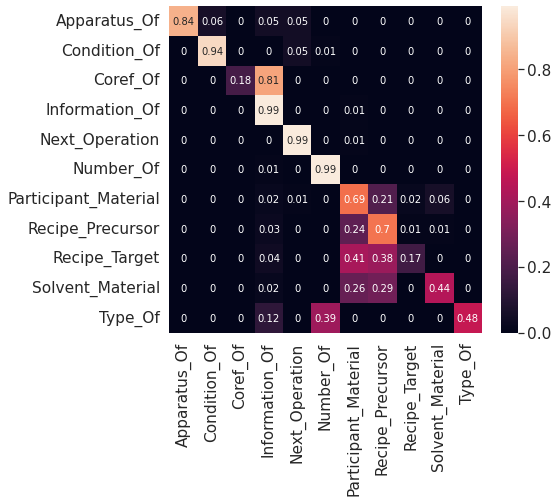

japflow_mscorpus_0.1



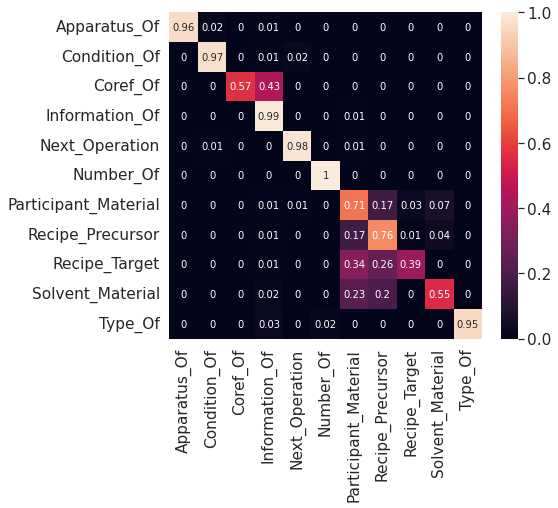

japflow_mscorpus_0.2



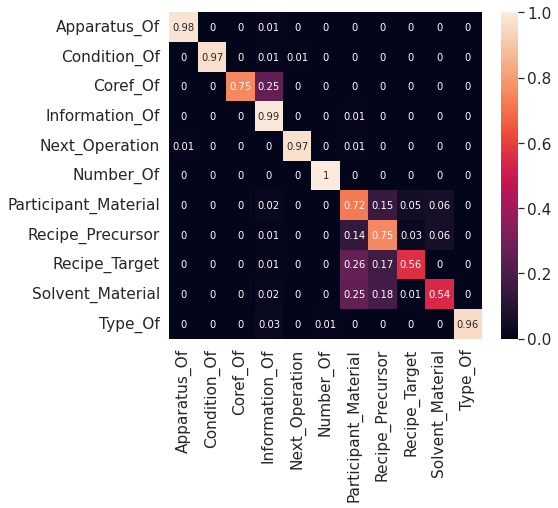

japflow_mscorpus_0.5



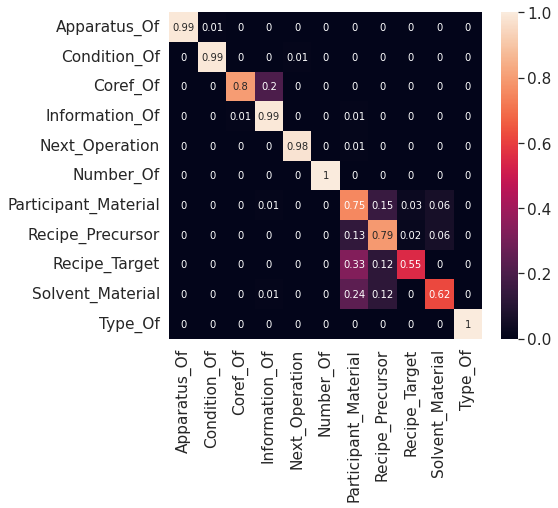

japflow_risec_0.01



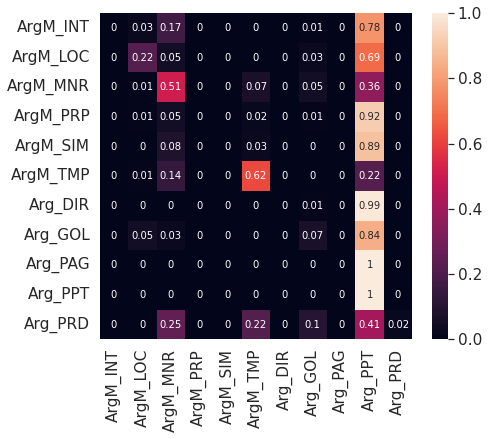

japflow_risec_0.05



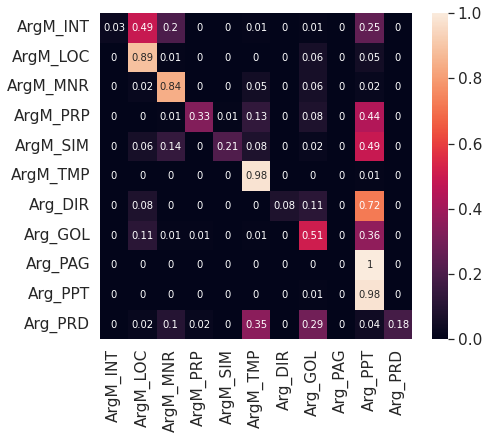

japflow_risec_0.1



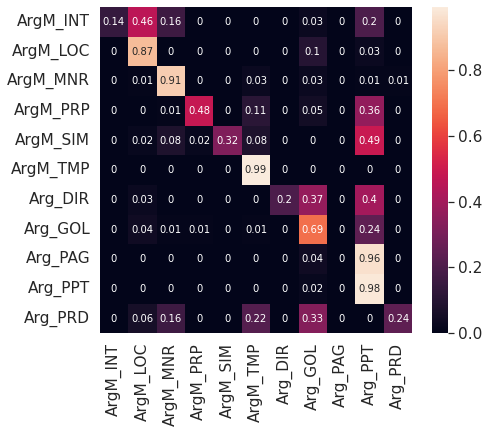

japflow_risec_0.2



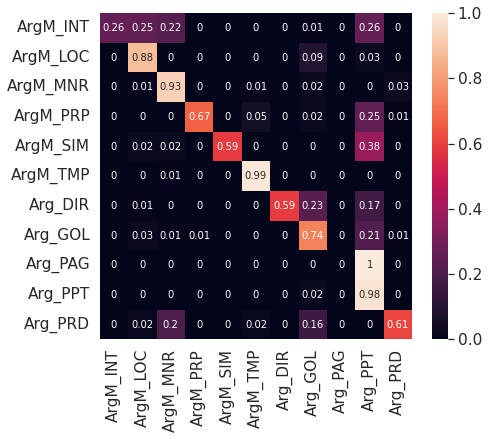

japflow_risec_0.5



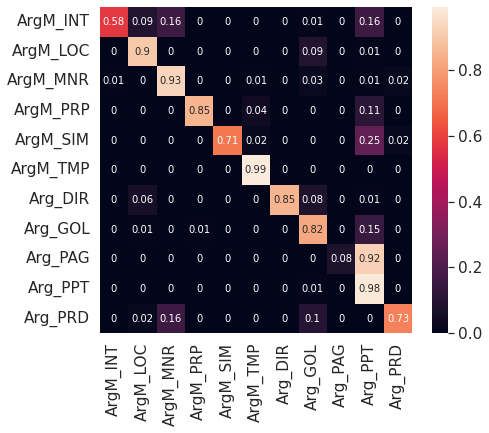

In [10]:
sns.set(rc={'figure.figsize':(7,6)})

for src_dataset in ['mscorpus','risec','japflow']:
    for tgt_dataset in ['mscorpus','risec','japflow']:
        if src_dataset == tgt_dataset: continue
        for fewshot in [0.01, 0.05, 0.1, 0.2, 0.5]:
            y_true, y_pred = [], []
            for seed in [0,1,2]:
                try:
                    csv_file = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_dep_residual.csv')
                    df       = pd.read_csv(csv_file)
                    labels   = sorted(list(set(df['labels'])))
                    y_true.extend(list(df['labels']))
                    y_pred.extend(list(df['predictions']))
                except Exception as e:
                    continue
                    # print(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_dep_residual.csv')
                    
            conf_matrix = cm(y_true, y_pred)
            df_cm = pd.DataFrame(conf_matrix, index = labels, columns=labels)    
            df_cm = df_cm.div(df_cm.sum(axis=1),axis=0)
            df_cm = df_cm.round(decimals = 2)

            sns.set(font_scale=1.4) # for label size
            sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
            
            print(f'{src_dataset}_{tgt_dataset}_{fewshot}\n')
            plt.savefig(f'../../figures/cm_{src_dataset}_{tgt_dataset}_{fewshot}_dep_residual.png', bbox_inches="tight")
            plt.show()
                    

## Creating the dependency dataframe

In [11]:
experiment_config   = 'dep_residual'
analysis_dict       = ddict(lambda: ddict(list))
configuration       = model_configurations[experiment_config]

deprel_dict         = load_deprels()
id2deprels          = [dep for dep in deprel_dict]

dep_dict            = ddict(list)

for dataset in ['mscorpus','risec','japflow']:
    dataset_loaded      = load_dataset(configuration["base_path"], dataset)
    cnt                 = 0
    for elem in tqdm(dataset_loaded['test']['rels']):
        depgraph_data = elem['dep_data']
        n1_mask, n2_mask = depgraph_data.n1_mask, depgraph_data.n2_mask

        if n1_mask.sum().item() ==1:
            n1_ids  = [(n1_mask==1).nonzero().item()]
        elif n1_mask.sum().item() > 1:
            n1_ids  = list(np.array((n1_mask==1).nonzero().squeeze()))

        if n2_mask.sum().item() ==1:
            n2_ids  = [(n2_mask==1).nonzero().item()]
        elif n2_mask.sum().item() > 1:
            n2_ids = list(np.array((n2_mask==1).nonzero().squeeze()))

        graph =  to_networkx(depgraph_data)
        # print(graph.nodes(), graph.edges())
        assert len(n1_ids) >0 and len(n2_ids) > 0
        assert len(graph.nodes()) == len(graph.edges())+1

        ugraph = graph.to_undirected()
        assert len(ugraph.nodes()) == len(ugraph.edges())+1
        
        
        spls  =  []
        for n1 in n1_ids:
            for n2 in n2_ids:
                spl = nx.shortest_path_length(ugraph, n1, n2)
                spls.append((spl, n1, n2))
            
        spl_val, n1, n2 = min(spls)
        
        if spl_val >= 1: 
            n_ids   = list(n1_ids)
            n_ids.extend(n2_ids)
            
            dep = None
            for i in range(0, len(depgraph_data.edge_type)):
                if depgraph_data.edge_index[0][i] in n_ids and depgraph_data.edge_index[1][i] in n_ids :
                    dep = id2deprels[depgraph_data.edge_type[i]]
            
        else:
            dep = None
        
        dep_dict['dataset'].append(dataset)
        dep_dict['dep_dist'].append(spl_val)
        dep_dict['dep_name'].append(dep)
        dep_dict['sent'].append(elem['sent'])

dep_df = pd.DataFrame(dep_dict)         
        

100%|██████████| 1745/1745 [00:03<00:00, 452.25it/s]


In [12]:
print(set(dep_dict['dep_name']))

for src_dataset  in ['mscorpus','risec','japflow']:
    curr_dep_df2     = dep_df[dep_df['dataset']== src_dataset ].reset_index().drop(columns=['index'])
    curr_dep_df2     = curr_dep_df2[curr_dep_df2['dep_dist']==1]
    print(len(set(curr_dep_df2['dep_name'])))


{None, 'det', 'discourse', 'dep', 'aux', 'amod', 'advmod', 'mark', 'cc', 'advcl', 'punct', 'nmod', 'case', 'parataxis', 'conj', 'obl', 'obj', 'acl', 'nsubj', 'nummod', 'xcomp', 'appos', 'compound', 'flat'}
21
13
19


# Distribution of dependency distances for different src, tgt pairs

In [13]:
perf_dist_dict             = ddict(list)

for src_dataset in ['mscorpus','risec','japflow']:
    for tgt_dataset in ['mscorpus','risec','japflow']:
        if src_dataset == tgt_dataset: continue
        curr_dep_df     = dep_df[dep_df['dataset']==tgt_dataset]
        # indices         = curr_dep_df[curr_dep_df['dep_dist']==1].index
        # dependencies    = curr_dep_df.loc(indices)['dep_name']
        dep_dists         = curr_dep_df['dep_dist']
        for fewshot in [0.01, 0.05, 0.1, 0.2, 0.5]:
            label_deps  = []
            dist_deps   = []
            pred_deps   = []
            for seed in [0,1,2]:
                try:
                    csv_file        = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_dep_residual.csv')
                    df              = pd.read_csv(csv_file)
                    # df              = df.loc(indices)
                    dist_deps.extend(dep_dists)
                    label_deps.extend(list(df['labels']))
                    pred_deps.extend(list(df['predictions']))
                except Exception as e:
                    continue
            
            preds       = []
            labels      = []
            dists       = []
            for seed in [0,1,2]:
                try:
                    csv_file        = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_plaintext.csv')
                    df              = pd.read_csv(csv_file)
                    # df              = df.loc(indices)
                    dists.extend(dep_dists)
                    labels.extend(list(df['labels']))
                    preds.extend(list(df['predictions']))
                except Exception as e:
                    continue
        
            curr_perf_baseline_dict  = ddict(list)        
            for dist, lbl, pred in zip(dists, labels, preds):
                if dist <=1:
                    dist2 = '1'
                elif dist < 3:
                    dist2 = '2'
                elif dist <=5:
                    dist2 = '2+'
                # else:
                #     dist2 = '5+'
                if lbl == pred:
                    curr_perf_baseline_dict[dist2].append(1)
                    curr_perf_baseline_dict['all'].append(1)
                else:
                    curr_perf_baseline_dict[dist2].append(0)
                    curr_perf_baseline_dict['all'].append(0)
            
                curr_perf_baseline_dict[dist2+'true'].append(lbl)
                curr_perf_baseline_dict[dist2+'pred'].append(pred)
                curr_perf_baseline_dict['alltrue'].append(lbl)
                curr_perf_baseline_dict['allpred'].append(pred)
            
            curr_perf_dep_dict  = ddict(list)        
            for dist, lbl, pred in zip(dist_deps, label_deps, pred_deps):
                if dist <=1:
                    dist2 = '1'
                elif dist < 3:
                    dist2 = '2'
                elif dist <=5:
                    dist2 = '2+'
                # else:
                #     dist2 = '5+'
                if lbl == pred:
                    curr_perf_dep_dict[dist2].append(1)
                    curr_perf_dep_dict['all'].append(1)
                else:
                    curr_perf_dep_dict[dist2].append(0)
                    curr_perf_dep_dict['all'].append(0)
                
                curr_perf_dep_dict[dist2+'true'].append(lbl)
                curr_perf_dep_dict[dist2+'pred'].append(pred)
                curr_perf_dep_dict['alltrue'].append(lbl)
                curr_perf_dep_dict['allpred'].append(pred)
                
                    
            for dist in ['1','2','2+','all']:
                perf_dist_dict['fewshot'].append(fewshot)
                perf_dist_dict['src'].append(src_dataset)
                perf_dist_dict['tgt'].append(tgt_dataset)
                perf_dist_dict['acc'].append(np.mean(curr_perf_dep_dict[dist]) - np.mean(curr_perf_baseline_dict[dist]) )
                
                dep_f1          = f1_score(curr_perf_dep_dict[dist+'true'], curr_perf_dep_dict[dist+'pred'], average='macro')
                baseline_f1     = f1_score(curr_perf_baseline_dict[dist+'true'], curr_perf_baseline_dict[dist+'pred'], average='macro')
                
                perf_dist_dict['f1'].append(dep_f1 - baseline_f1)
                perf_dist_dict['dist'].append(dist)

        
perf_dist_df = pd.DataFrame(perf_dist_dict)


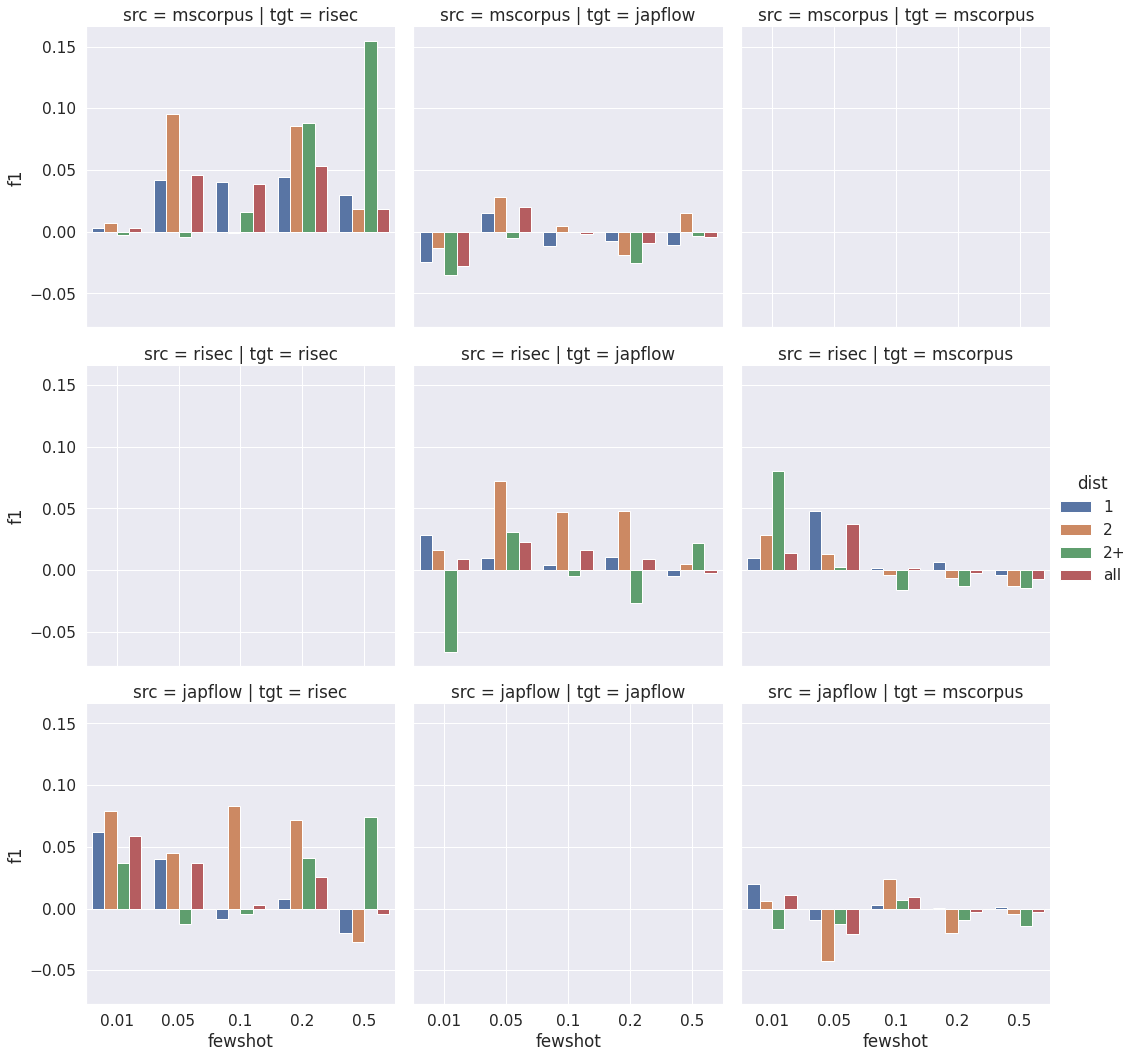

In [14]:
# F1 score as the means of comparison
g=sns.catplot(data=perf_dist_df, x="fewshot", y="f1", hue='dist', col="tgt", row='src', kind="bar") 
plt.show()

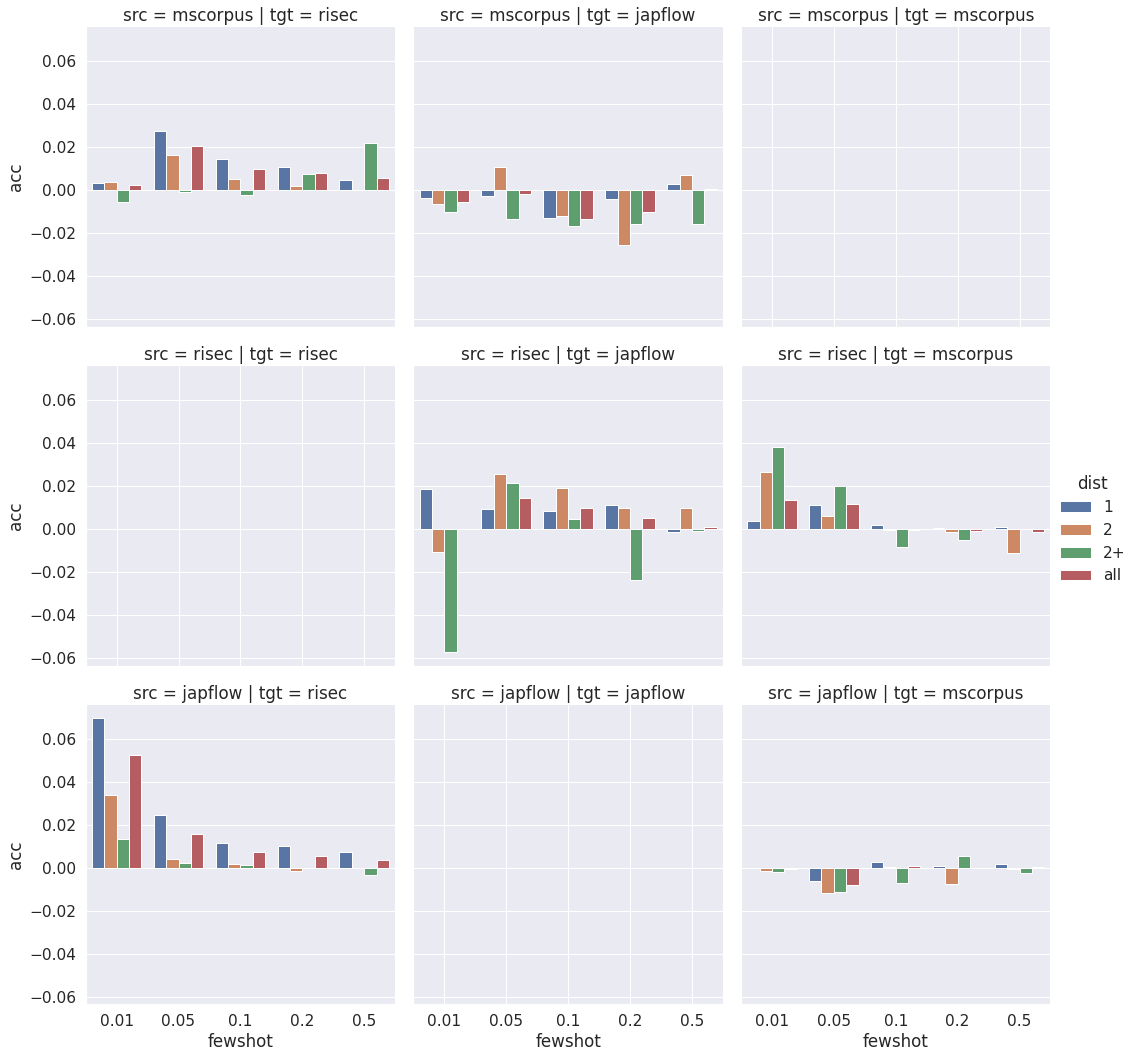

In [15]:
# Accuracy
g=sns.catplot(data=perf_dist_df, x="fewshot", y="acc", hue='dist', col="tgt", row='src', kind="bar") 
plt.show()

## Distribution of the single-link dependency relations 

In [16]:
perf_dep_dict             = ddict(list)

for src_dataset  in ['mscorpus','risec','japflow']:
    for tgt_dataset  in ['mscorpus','risec','japflow']:
        if src_dataset == tgt_dataset: continue
        curr_dep_df     = dep_df[dep_df['dataset']== tgt_dataset ].reset_index().drop(columns=['index'])
        indices         = list(curr_dep_df[curr_dep_df['dep_dist']==1].index)
        dependencies    = curr_dep_df.iloc[indices]['dep_name']
        
        
        for fewshot in [0.01, 0.05, 0.1, 0.2, 0.5]:
            labels                  = []
            preds                   = []
            depnames                = []
            for seed in [0,1,2]:
                try:
                    csv_file        = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_dep_residual.csv')
                    df              = pd.read_csv(csv_file)
                    df              = df.iloc[indices]
                    depnames.extend(dependencies)
                    labels.extend(list(df['labels']))
                    preds.extend(list(df['predictions']))
                except Exception as e:
                    continue
        
            curr_perf_dep_dict  = ddict(list)        
            for depname, lbl, pred in zip(depnames, labels, preds):
                if lbl == pred:
                    curr_perf_dep_dict[depname].append(1)
                else:
                    curr_perf_dep_dict[depname].append(0)
                    
                curr_perf_dep_dict[depname+'_true'].append(lbl)
                curr_perf_dep_dict[depname+'_pred'].append(pred)

            for depname in curr_perf_dep_dict:
                if '_' in depname: continue
                
                perf_dep_dict['fewshot'].append(fewshot)
                perf_dep_dict['src'].append(src_dataset)
                perf_dep_dict['tgt'].append(tgt_dataset)
                perf_dep_dict['acc'].append(np.mean(curr_perf_dep_dict[depname]))
                perf_dep_dict['f1'].append(f1_score(curr_perf_dep_dict[depname+'_true'], curr_perf_dep_dict[depname+'_pred'], average='macro'))
                perf_dep_dict['dep'].append(depname)
                    
perf_dep_df = pd.DataFrame(perf_dep_dict)

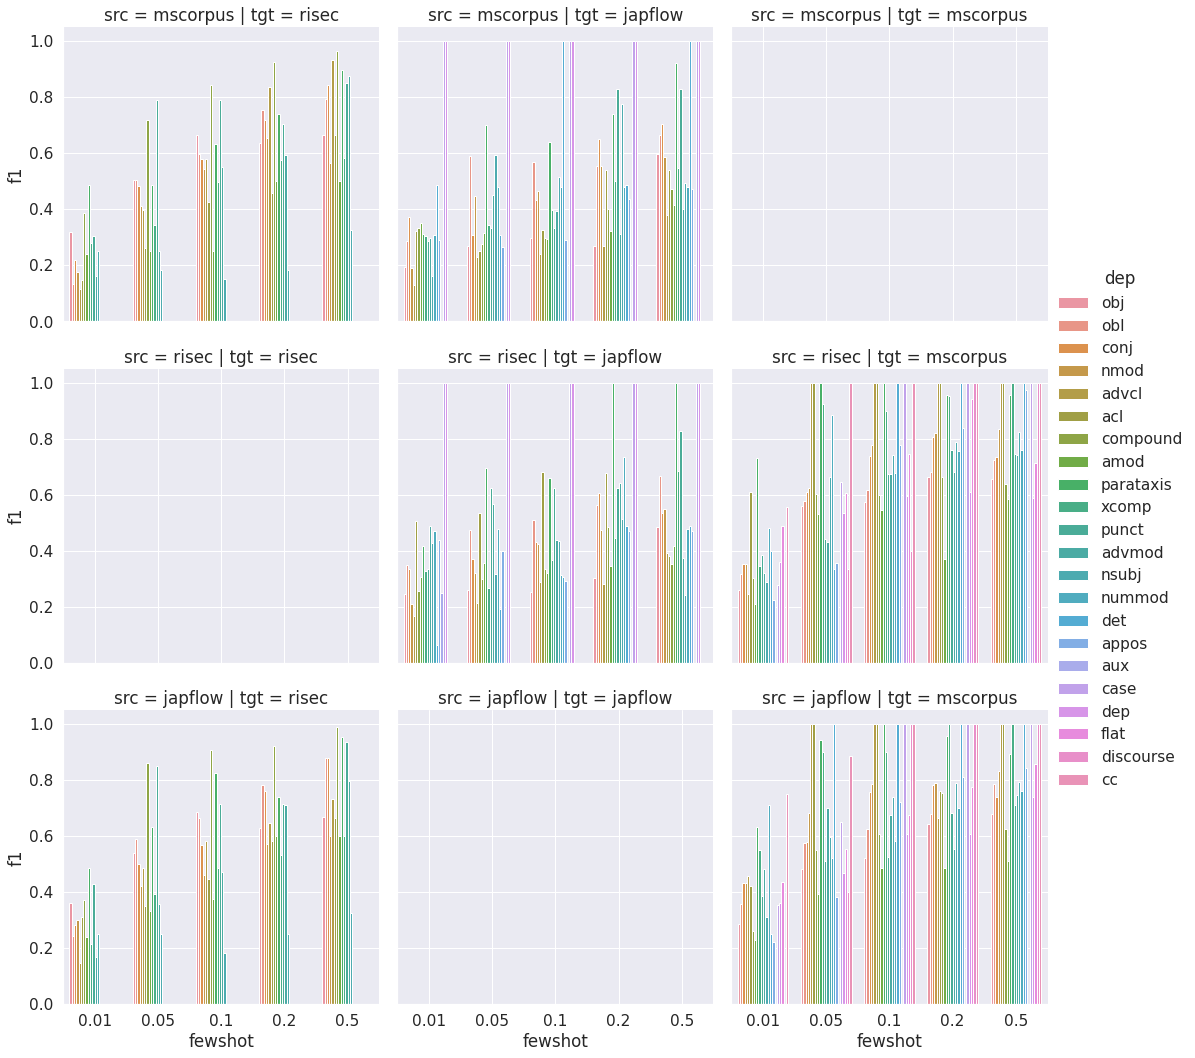

In [17]:
g=sns.catplot(data=perf_dep_df, x="fewshot", y="f1", hue='dep', col="tgt", row='src', kind="bar") 
plt.show()

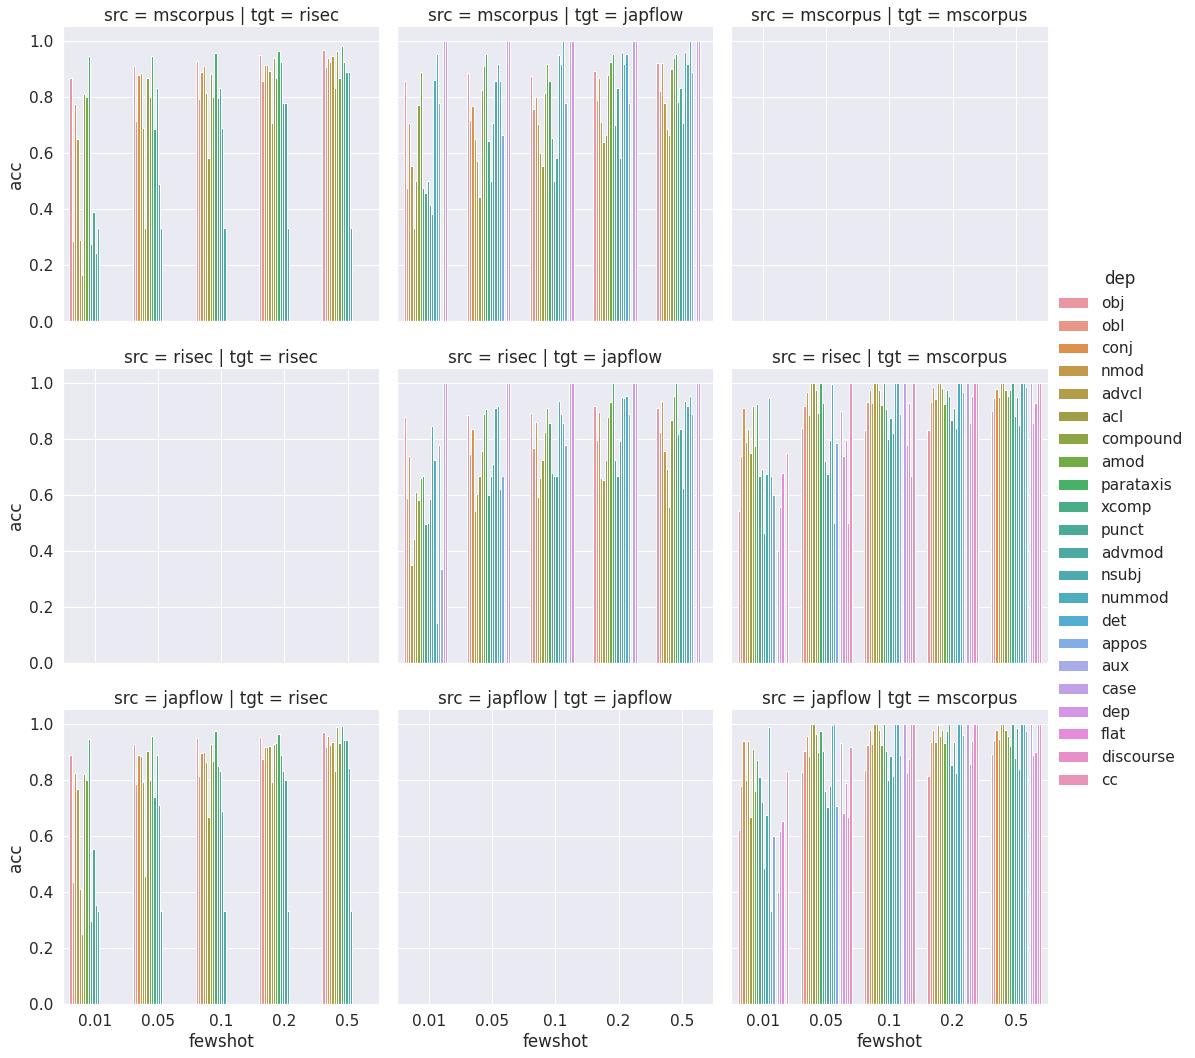

In [18]:
g=sns.catplot(data=perf_dep_df, x="fewshot", y="acc", hue='dep', col="tgt", row='src', kind="bar") 
plt.show()

### Compare the correlations between the performance and the distribution of the dependency in src/tgt

In [19]:
display(perf_dep_df.head())

display(dep_freq_df.head())

print(len(perf_dep_df), len(dep_freq_df))

,fewshot,src,tgt,acc,f1,dep
0,0.01,mscorpus,risec,0.867830,0.318254,obj
1,0.01,mscorpus,risec,0.288156,0.133555,obl
2,0.01,mscorpus,risec,0.776557,0.218986,conj
3,0.01,mscorpus,risec,0.652330,0.176778,nmod
4,0.01,mscorpus,risec,0.291667,0.116284,advcl


,dataset,dep,freq
0,mscorpus,amod,6.296394
1,mscorpus,appos,5.381760
2,mscorpus,nummod,23.396076
3,mscorpus,nmod,6.495228
4,mscorpus,nsubj,10.034464


530 66


In [20]:
src_corr_dep_df = pd.merge(perf_dep_df, dep_freq_df, left_on =['src','dep'], right_on =['dataset','dep'])

src_corr_dict           = ddict(list)

for src_dataset  in ['mscorpus','risec','japflow']:
    for tgt_dataset  in ['mscorpus','risec','japflow']:
        if src_dataset == tgt_dataset: continue
        for fewshot in [0.01,   0.05,   0.1,    0.2,    0.5]:
            curr_df     = src_corr_dep_df[(src_corr_dep_df['src']==src_dataset) & (src_corr_dep_df['tgt']==tgt_dataset) & (src_corr_dep_df['fewshot']==fewshot)]
            f1_corr     = curr_df['f1'].corr(curr_df['freq'])
            acc_corr    = curr_df['acc'].corr(curr_df['freq'])
            
            src_corr_dict['src'].append(src_dataset)
            src_corr_dict['tgt'].append(tgt_dataset)
            src_corr_dict['fewshot'].append(fewshot)
            src_corr_dict['src'].append(src_dataset)
            src_corr_dict['tgt'].append(tgt_dataset)
            src_corr_dict['fewshot'].append(fewshot)
            src_corr_dict['perf'].append(f1_corr)
            src_corr_dict['metric'].append('f1')
            src_corr_dict['dom'].append('src')
            src_corr_dict['perf'].append(acc_corr)
            src_corr_dict['metric'].append('acc')
            src_corr_dict['dom'].append('src')
            
src_corr_df         = pd.DataFrame(src_corr_dict)

In [21]:
tgt_corr_dep_df = pd.merge(perf_dep_df, dep_freq_df, left_on =['tgt','dep'], right_on =['dataset','dep'])

tgt_corr_dict           = ddict(list)

for src_dataset  in ['mscorpus','risec','japflow']:
    for tgt_dataset  in ['mscorpus','risec','japflow']:
        if src_dataset == tgt_dataset: continue
        for fewshot in [0.01,   0.05,   0.1,    0.2,    0.5]:
            curr_df     = tgt_corr_dep_df[(tgt_corr_dep_df['src']==src_dataset) & (tgt_corr_dep_df['tgt']==tgt_dataset) & (tgt_corr_dep_df['fewshot']==fewshot)]
            f1_corr     = curr_df['f1'].corr(curr_df['freq'])
            acc_corr    = curr_df['acc'].corr(curr_df['freq'])
            
            tgt_corr_dict['src'].append(src_dataset)
            tgt_corr_dict['tgt'].append(tgt_dataset)
            tgt_corr_dict['fewshot'].append(fewshot)
            tgt_corr_dict['src'].append(src_dataset)
            tgt_corr_dict['tgt'].append(tgt_dataset)
            tgt_corr_dict['fewshot'].append(fewshot)
            tgt_corr_dict['perf'].append(f1_corr)
            tgt_corr_dict['metric'].append('f1')
            tgt_corr_dict['dom'].append('tgt')
            tgt_corr_dict['perf'].append(acc_corr)
            tgt_corr_dict['metric'].append('acc')
            tgt_corr_dict['dom'].append('tgt')
            
tgt_corr_df         = pd.DataFrame(tgt_corr_dict)

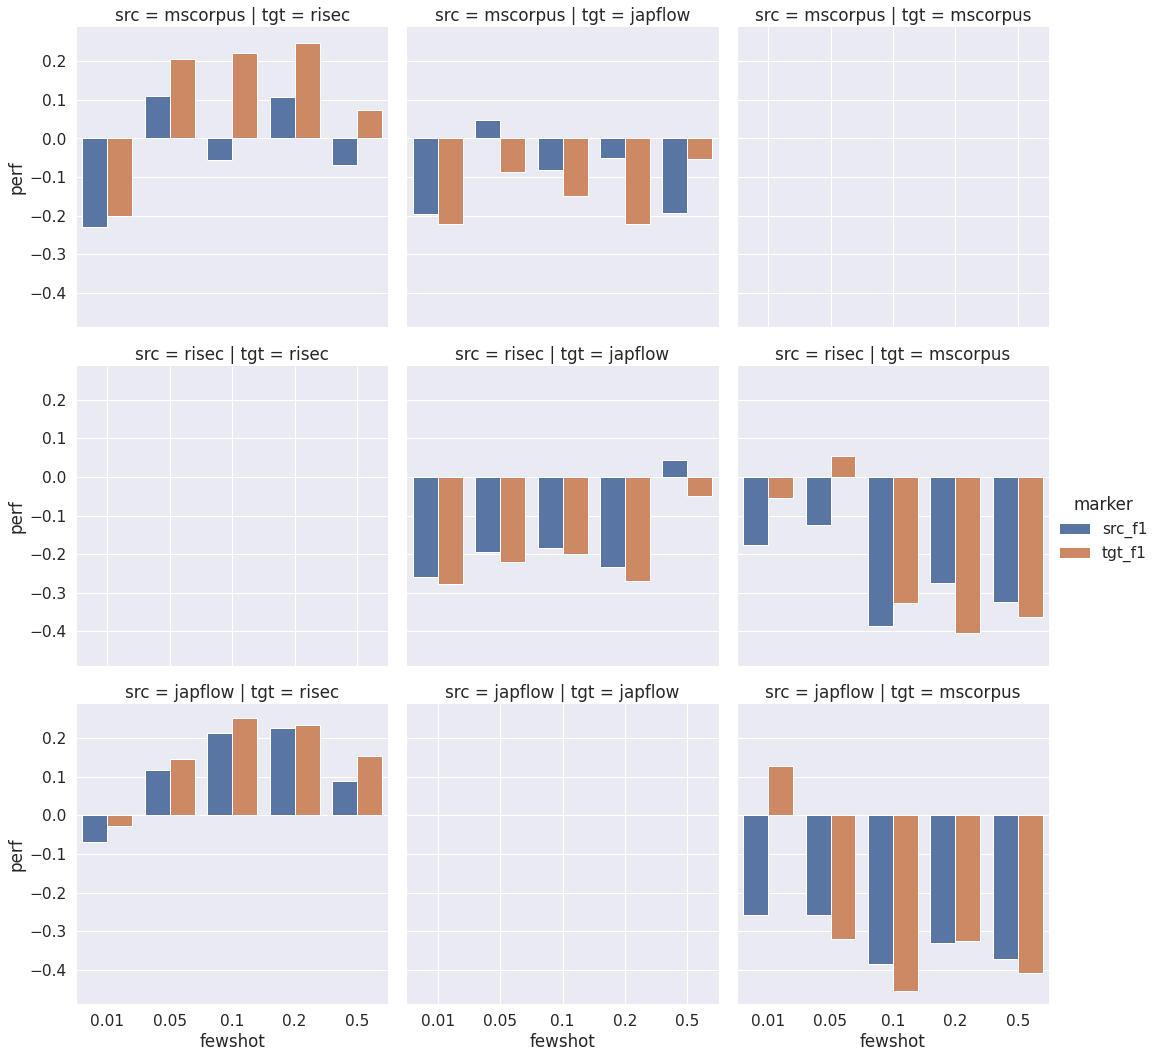

In [22]:
corr_df = pd.concat([src_corr_df, tgt_corr_df])

markers = []
for index, row in corr_df.iterrows():
    marker = f"{row['dom']}_{row['metric']}"
    markers.append(marker)
    
corr_df['marker']= markers

g=sns.catplot(data=corr_df, x="fewshot", y="perf", col="tgt", row='src', kind="bar", hue='marker', hue_order=['src_f1','tgt_f1']) 
plt.show()


## Observing Correlation using a LINEAR REGRESSION MODEL 

In [23]:
src_corr_dep_df = pd.merge(perf_dep_df, dep_freq_df, left_on =['src','dep'], right_on =['dataset','dep'])

src_corr_reg_dict           = ddict(list)

from sklearn.linear_model import ElasticNet, LinearRegression

for src_dataset  in ['mscorpus','risec','japflow']:
    for tgt_dataset  in ['mscorpus','risec','japflow']:
        if src_dataset == tgt_dataset: continue
        for fewshot in [0.01,   0.05,   0.1,    0.2,    0.5]:
            curr_df            = src_corr_dep_df[(src_corr_dep_df['src']==src_dataset) & (src_corr_dep_df['tgt']==tgt_dataset) & (src_corr_dep_df['fewshot']==fewshot)]
            # f1_regr            = ElasticNet(random_state=0)
            # acc_regr           = ElasticNet(random_state=0)
            
            f1_regr            = LinearRegression(fit_intercept=False)
            acc_regr           = LinearRegression(fit_intercept=False)
            
            
            X, y_acc, y_f1     = list(curr_df['freq']), list(curr_df['acc']), list(curr_df['f1'])
            X                  = [[x] for x in X]
            y_acc              = [[x] for x in y_acc]
            y_f1               = [[x] for x in y_f1]
            
            f1_regr.fit(X, y_f1)
            acc_regr.fit(X, y_acc)
            
            f1_corr             = f1_regr.coef_[0][0]
            acc_corr            = acc_regr.coef_[0][0]
            
            src_corr_reg_dict['src'].append(src_dataset)
            src_corr_reg_dict['tgt'].append(tgt_dataset)
            src_corr_reg_dict['fewshot'].append(fewshot)
            src_corr_reg_dict['src'].append(src_dataset)
            src_corr_reg_dict['tgt'].append(tgt_dataset)
            src_corr_reg_dict['fewshot'].append(fewshot)
            src_corr_reg_dict['perf'].append(f1_corr)
            src_corr_reg_dict['metric'].append('f1')
            src_corr_reg_dict['dom'].append('src')
            src_corr_reg_dict['perf'].append(acc_corr)
            src_corr_reg_dict['metric'].append('acc')
            src_corr_reg_dict['dom'].append('src')
            
src_corr_reg_df         = pd.DataFrame(src_corr_reg_dict)


In [24]:
tgt_corr_dep_df = pd.merge(perf_dep_df, dep_freq_df, left_on =['tgt','dep'], right_on =['dataset','dep'])

tgt_corr_reg_dict           = ddict(list)
from sklearn.linear_model import ElasticNet

for src_dataset  in ['mscorpus','risec','japflow']:
    for tgt_dataset  in ['mscorpus','risec','japflow']:
        if src_dataset == tgt_dataset: continue
        for fewshot in [0.01,   0.05,   0.1,    0.2,    0.5]:
            curr_df     = tgt_corr_dep_df[(tgt_corr_dep_df['src']==src_dataset) & (tgt_corr_dep_df['tgt']==tgt_dataset) & (tgt_corr_dep_df['fewshot']==fewshot)]
            
            # f1_regr            = ElasticNet(random_state=0)
            # acc_regr           = ElasticNet(random_state=0)
            f1_regr            = LinearRegression(fit_intercept=False)
            acc_regr           = LinearRegression(fit_intercept=False)
            
            
            X, y_acc, y_f1     = list(curr_df['freq']), list(curr_df['acc']), list(curr_df['f1'])
            X                  = [[x] for x in X]
            y_acc              = [[x] for x in y_acc]
            y_f1               = [[x] for x in y_f1]
            
            f1_regr.fit(X, y_f1)
            acc_regr.fit(X, y_acc)
            
            f1_corr             = f1_regr.coef_[0][0]
            acc_corr            = acc_regr.coef_[0][0]
            
            
            tgt_corr_reg_dict['src'].append(src_dataset)
            tgt_corr_reg_dict['tgt'].append(tgt_dataset)
            tgt_corr_reg_dict['fewshot'].append(fewshot)
            tgt_corr_reg_dict['src'].append(src_dataset)
            tgt_corr_reg_dict['tgt'].append(tgt_dataset)
            tgt_corr_reg_dict['fewshot'].append(fewshot)
            tgt_corr_reg_dict['perf'].append(f1_corr)
            tgt_corr_reg_dict['metric'].append('f1')
            tgt_corr_reg_dict['dom'].append('tgt')
            tgt_corr_reg_dict['perf'].append(acc_corr)
            tgt_corr_reg_dict['metric'].append('acc')
            tgt_corr_reg_dict['dom'].append('tgt')
            
tgt_corr_reg_df         = pd.DataFrame(tgt_corr_reg_dict)

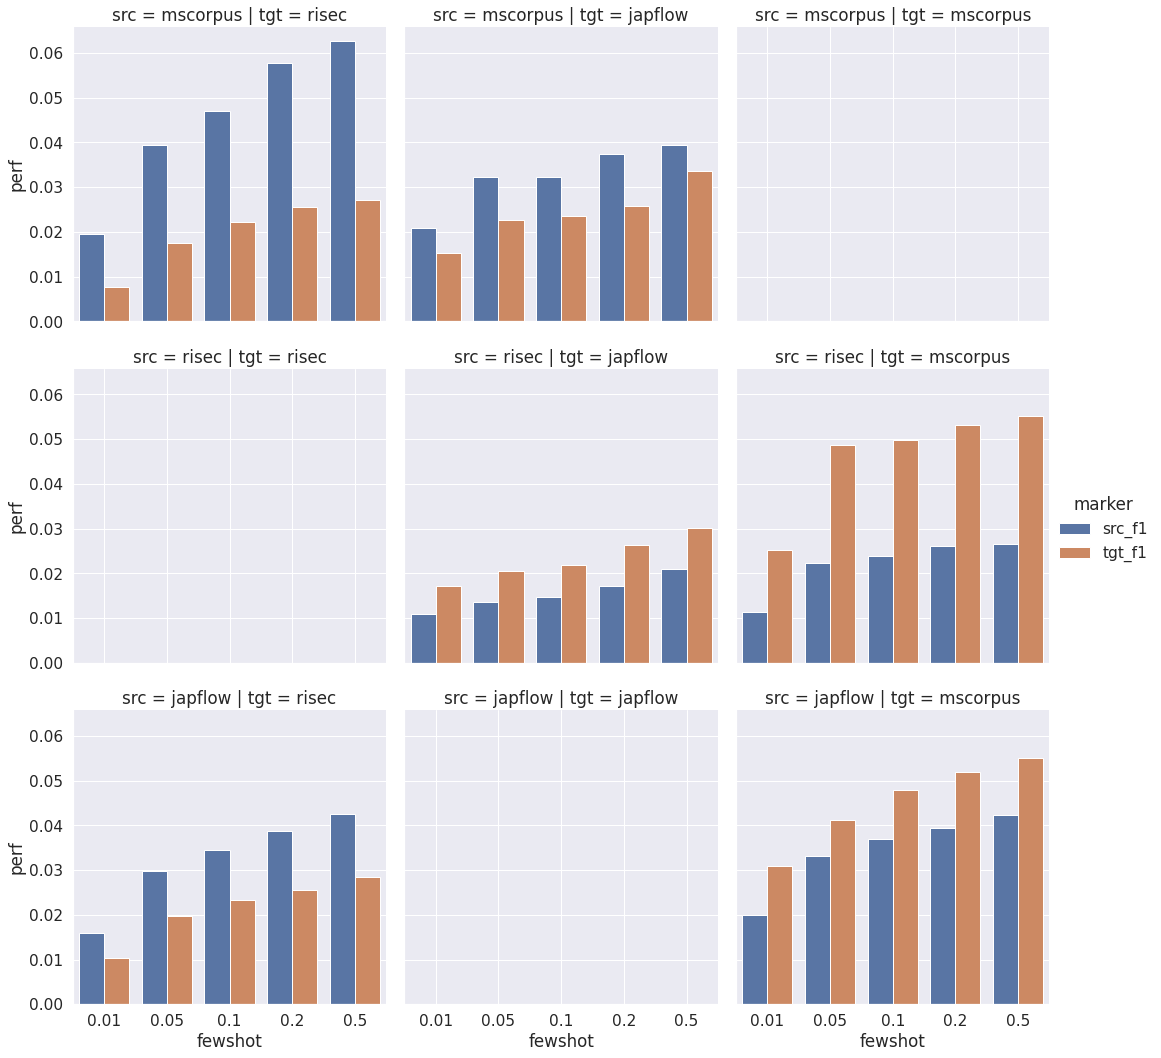

In [25]:
corr_df = pd.concat([src_corr_reg_df, tgt_corr_reg_df])

markers = []
for index, row in corr_df.iterrows():
    marker = f"{row['dom']}_{row['metric']}"
    markers.append(marker)
    
corr_df['marker']= markers

g=sns.catplot(data=corr_df, x="fewshot", y="perf", col="tgt", row='src', kind="bar", hue='marker', hue_order=['src_f1','tgt_f1'])#'src_acc','tgt_acc']) 
plt.show()


In [2]:
# Generalizing amongst the pair of corpora, observe if there are pivot relations; for example pivot relations are they more prominent 

# Figure out the bias for each corpus and how the bias is different across corpus.

# FEDA approach instead of zero-shot to observe how the difference in relations holds; observe if the form change holds as well.

In [3]:
all_possible_tups = ddict(lambda: ddict(int))

for dataset in ['mscorpus','japflow','risec']:
    dataset_loaded      = load_dataset(configuration["base_path"], dataset)

    for elem in tqdm(dataset_loaded['train']['rels']):
        e1_type, e2_type = elem['span_info'][3], elem['span_info'][7]
        all_possible_tups[dataset][(e1_type, e2_type)]+=1

print("All Possible relations")
for dataset in all_possible_tups:
    print(dataset, len(all_possible_tups[dataset]))

print("Relations with only 1 dependency distance between them")

for dataset in ['mscorpus','risec','japflow']:
    print(dataset, len(analysis_dict[dataset]))

NameError: name 'ddict' is not defined

In [27]:
for tup in analysis_dict['risec']:
    if len(analysis_dict['risec'][tup]) < 5: continue
    
    out_file = open(f'dep_risec/risec_{tup}.txt','w')
    
    for elem in analysis_dict['risec'][tup]:
        sent       = elem['sent']
        sent_start = elem['sent_start']
        sent_end   = len(elem['sent'])
        
        e1_start, e1_end, e2_start, e2_end = elem['span_info'][0]-sent_start, elem['span_info'][1] - sent_start, elem['span_info'][4] - sent_start, elem['span_info'][5] - sent_start
        
        if e1_end < e2_start:
            new_sent = f'{sent[0:e1_start]}<E1>{sent[e1_start:e1_end]}</E1>{sent[e1_end:e2_start]}<E2>{sent[e2_start:e2_end]}</E2>{sent[e2_end:]}'
        
        if e2_end < e1_start:
            new_sent = f'{sent[0:e2_start]}<E2>{sent[e2_start:e2_end]}</E2>{sent[e2_end:e1_start]}<E1>{sent[e1_start:e1_end]}</E1>{sent[e1_end:]}'
        
        out_file.write('\n-------------------------------------------------------\n')    
        out_file.write(new_sent.strip())
        out_file.write('\n-------------------------------------------------------\n')
        print(sent)
        print(new_sent)    
        


In [28]:
analysis_dict['risec'].keys()

dict_keys([])

In [29]:
gdata = dataset_loaded['train']['rels'][0]['dep_data']

graph =  to_networkx(gdata, to_undirected=True)

src_idx  = gdata.n1_mask.index(1)


print(graph)

AttributeError: 'Tensor' object has no attribute 'index'

In [ ]:
graph.nodes()
graph.edges()

OutEdgeView([(1, 2), (2, 11), (3, 1), (4, 5), (5, 2), (6, 5), (7, 8), (8, 5), (9, 8), (10, 2), (11, 0), (12, 2), (13, 14), (14, 2), (15, 16), (16, 17), (17, 14), (18, 16), (19, 20), (20, 14), (21, 2)])

In [ ]:
src_idx  = (gdata.n1_mask==1).nonzero().item()

tgt_idx  = list(np.array((gdata.n2_mask==1).nonzero().squeeze()))

print(src_idx, tgt_idx)


2 [5, 6]


In [ ]:
gdata.n1_mask.sum().item()



1